# Xplainable methods Guide

In this notebook we present several Xplainable methods that are used in nowdays AI projects. Our aim is to get deeper understanding on these methods, therefore, we apply them on datasets that are publicly available such as: 

1. Dataset previously processed in the Sorbonne Data Challenge:

This dataset .. 

2. XXX from website:

Dataset description. 

In this notebook, we will present the methods: 

- Golbal: 
  - Shap
  - PDP
  - ALE
  - LOFO

- Local:
  - Lime
  - ICE
  - Anchors
  - Shap 

### Libraries

In [1]:
### For Data treatment
import pandas as pd 
import numpy as np 
import pickle

### For Model training and Evaluation
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

### For Visualisation
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

### Dataset - Sorbonne Data Challenge

In [2]:
X_train = pd.read_csv('../dataset/x_train.csv', index_col= 0)
X_test = pd.read_csv('../dataset/x_test.csv', index_col= 0)

y_train = pd.read_csv('../dataset/y_train.csv', index_col= 0)
y_test = pd.read_csv('../dataset/y_test.csv', index_col= 0)

### Model - Trained and saved

In [3]:
filename = '../trained_model/hgb.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

### **Explainable Methods**

#### **Shap** - Global and Local

La méthode **SHAP** (SHapley Additive exPlanations) est une approche d'interprétabilité des modèles d'apprentissage automatique basée sur la théorie des jeux coopératifs. Elle attribue à chaque caractéristique (feature) une valeur d'importance, appelée *valeur de Shapley*, qui reflète sa contribution à la prédiction du modèle.

**Objectif de SHAP**

L'objectif principal de SHAP est d'expliquer la prédiction d'un modèle pour une instance $x$ donnée en la décomposant comme une somme de contributions individuelles de chaque caractéristique. SHAP calcule les valeurs de Shapley en considérant les valeurs des caractéristiques comme des joueurs dans une coalition, et la prédiction comme un gain à répartir équitablement entre eux.

le modele est défini comme suit :

$$
g(z') = \phi_0 + \sum_{j=1}^{M} \phi_j z'_j
$$

où :
- $g$ est le modèle explicatif,
- $z' \in \{0,1\}^M$ est le **vecteur de coalition**,
- $M$ est le nombre total de caractéristiques,
- $\phi_j$ est la valeur de Shapley pour la caractéristique $j$.

Si toutes les caractéristiques sont présentes dans la coalition ($z'$ est un vecteur de 1), l’équation devient :

$$
g(x') = \phi_0 + \sum_{j=1}^{M} \phi_j
$$

l'innovation dans avec ce modele c'est qu'il rend les valeurs de Shapley sous forme de modèle additif.

**Les valeurs de Shapley**

Les **valeurs de Shapley** proviennent de la théorie des jeux coopératifs. L'idée est d'estimer la contribution individuelle d'un joueur (ici une caractéristique) à une coalition (ici une prédiction) en moyenne sur toutes les permutations possibles des joueurs.

Formellement, la valeur de Shapley pour la caractéristique \( i \) est définie comme :

$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \cdot [f_{S \cup \{i\}}(x_{S \cup \{i\}}) - f_S(x_S)]
$$

Où :
- $N$ est l'ensemble de toutes les caractéristiques,
- $S$ est un sous-ensemble de $N$ ne contenant pas $i$,
- $f_S(x_S)$ est la prédiction du modèle en ne considérant que les caractéristiques dans $S$ \)$.

Les valeurs de Shapley possèdent plusieurs propriétés importantes qui en font un choix idéal pour l'interprétation :

- **Efficience** : La somme des contributions est égale à l'écart entre la prédiction et la valeur moyenne.
- **Symétrie** : Deux caractéristiques ayant le même impact sur la prédiction obtiennent la même valeur.
- **Nullité** : Si une caractéristique n'affecte jamais la sortie, sa valeur est zéro.
- **Additivité** : Pour deux modèles, les valeurs SHAP d'un modèle combiné sont la somme des valeurs SHAP des modèles individuels.

Parcontre, le calcul exact des valeurs de Shapley nécessite d’examiner toutes les coalitions possibles qui est exponentiel en $O(2^n)$ et ainsi un probléme de complexité apparaitre. 


##### **Global Shap**

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 18420/18481 [02:58<00:00]        

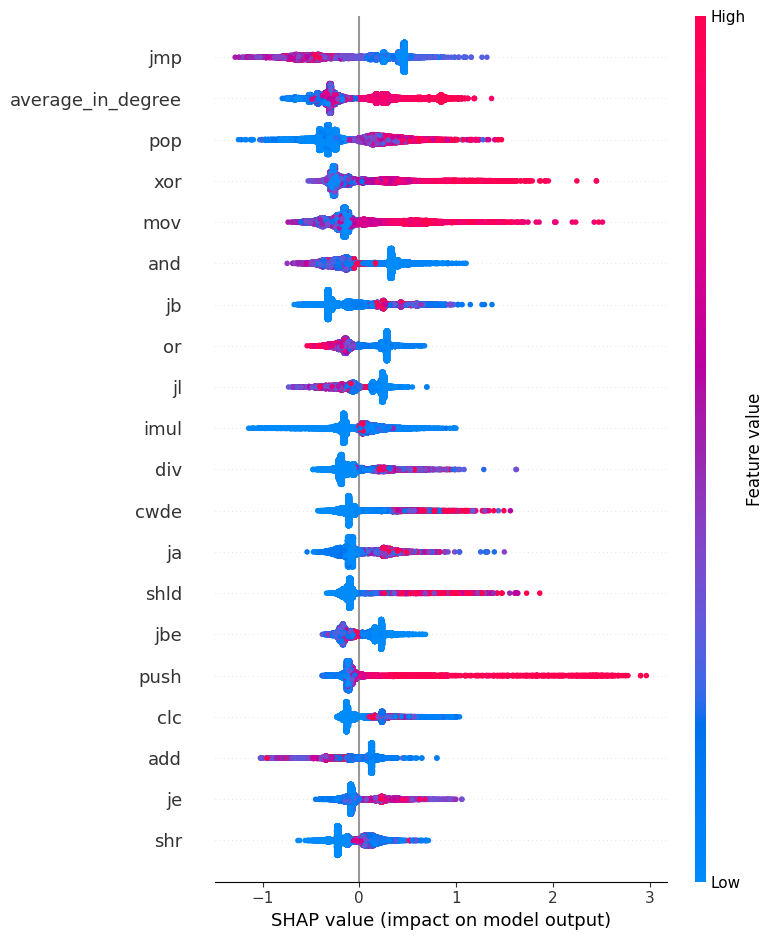

In [4]:
import shap

y_pred = model.predict(X_test)

first_label_classifier = model.estimators_[0]
sample_idx = 0
sample = X_train.iloc[sample_idx:sample_idx+1]

# Appliquer SHAP
explainer = shap.Explainer(first_label_classifier, X_train)
shap_values = explainer.shap_values(X_train, check_additivity=False)


#shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

##### **Local Shap**

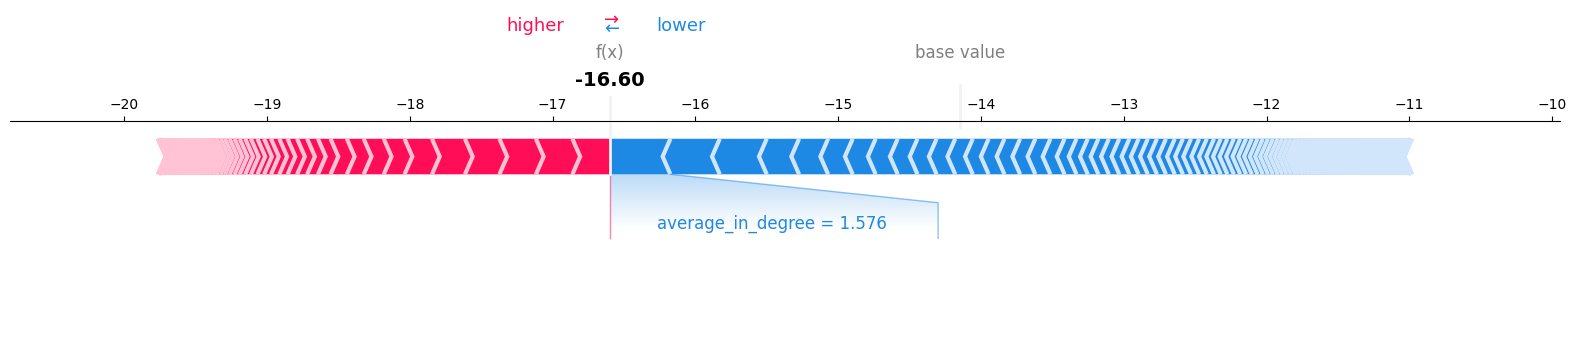

In [5]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2], sample.apply(lambda x : x.round(3)), matplotlib=True)

#### **PDP** - Global

Le **Partial Dependence Plot (PDP)** est une méthode d’interprétabilité globale utilisée pour visualiser la relation entre une ou plusieurs caractéristiques d’entrée et la prédiction d’un modèle d’apprentissage automatique. Elle permet de répondre à la question : _« Quelle est l'influence moyenne d'une variable sur la sortie du modèle ? »_

Le PDP estime l'effet marginal d'une ou plusieurs variables d’entrée $x_S \subset x$ sur la prédiction du modèle $f(x)$, en marginalisant les autres variables $x_C = x \setminus x_S$.

La fonction de dépendance partielle est définie comme :

$$
\hat{f}_S(x_S) = \mathbb{E}_{x_C}[\hat{f}(x_S, X_C)]
$$

Où :
- $S$ est le sous-ensemble de caractéristiques d'intérêt,
- $C$ est le complément de $S$,
- $\hat{f}_S(x_S)$ est la prédiction moyenne lorsque $x_S$ est fixé et que $x_C$ varie selon sa distribution dans les données.

**Méthode de calcul**

En pratique, l'espérance est approximée par la moyenne empirique sur un échantillon de données :

$$
\hat{f}_S(x_S) \approx \frac{1}{n} \sum_{i=1}^{n} f(x_S, x_C^{(i)})
$$

Chaque $x_C^{(i)}$ est une observation réelle tirée du jeu de données. Pour chaque valeur de $x_S$, on remplace cette valeur dans tout l’échantillon, et on calcule la moyenne des prédictions du modèle.


PDP est souvent utilisé pour :
- Interpréter les modèles complexes (arbres, forêts, réseaux neuronaux).
- Identifier les effets non-linéaires ou d’interaction.


mais il prensete des limites comme:

- **Suppose l’indépendance entre les variables** : Si les variables sont corrélées, les combinaisons artificielles générées lors de la marginalisation peuvent être peu probables ou impossibles dans la réalité.
- **Effet de l’hétérogénéité locale** : Le PDP masque les effets d’interactions locales ou d’hétérogénéité conditionnelle. Pour cela, les méthodes comme les **Individual Conditional Expectation (ICE)** plots sont plus adaptées, l'ICE est presentée avec les methodes locales.

En 2018, Greenwell, Boehmke, and McCarthy ont proposé **PD-base feature importance** mais elle est aussi basée sur la supposition de l'independance entre les variables. Une solution pour ce problème est l'utilisation de l'Acculumated Local Effect (ALE) plots. Cette methode est basée sur la distribution conditionnel a la place de la distribution mariginale et elle est presentée dans la section suivante. 

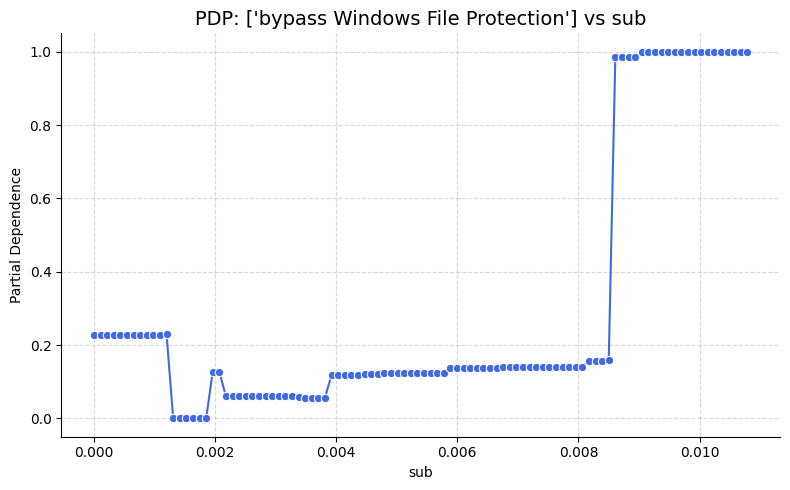

In [6]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# Choose a feature to inspect
feature_to_plot = 'sub'  # e.g., 'age', 'height', etc.
label_names= ['bypass Windows File Protection']

# Loop through each binary classifier in OVR
for i, estimator in enumerate(model.estimators_[:1]):

    # PDP for one feature
    #PartialDependenceDisplay.from_estimator(estimator, X, [feature_to_plot])
    #plt.title(f'PDP for class: {label_names[i]} - Feature: {feature_to_plot}')
    #plt.show()
    
    # Get PDP values
    pdp_result = partial_dependence(estimator, X_test, [feature_to_plot], kind='average')

    # Extract values
    scaler = MinMaxScaler()
    
    feature_values = pdp_result['grid_values'][0]
    pdp_values = pdp_result['average'][0]
    
    # Ensure feature_values is a NumPy array
    #feature_values = np.array(pdp_result['grid_values'][0]).reshape(-1, 1)
    pdp_values = np.array(pdp_result['average'][0]).reshape(-1, 1)
    
    #feature_values_scaled = scaler.fit_transform(feature_values).flatten()
    pdp_values_scaled = scaler.fit_transform(pdp_values).flatten()

    # Put into DataFrame
    df_pdp = pd.DataFrame({
        feature_to_plot: feature_values,
        'Partial Dependence': pdp_values_scaled
    })

    # Plot with Seaborn
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_pdp, x=feature_to_plot, y='Partial Dependence', marker='o', color='royalblue')
    sns.despine()
    plt.title(f"PDP: {label_names} vs {feature_to_plot}", fontsize=14)
    plt.xlabel(feature_to_plot)
    plt.ylabel("Partial Dependence")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Dans la figure precedente on présente le PDP plot pour la variable 'by pass windows File Protection'. Ce plot présente l'impacte de la valeur de cette variable sur la prédiction du modèle. Pour des faibles valeurs (plus petite que 0.008) l'impacte est faible parcontre l'impacte augmente pour les valeurs plus importantes.

#### **ALE** - Global

In [30]:
from alibi.explainers import ALE, plot_ale

In [31]:
X_train = X_train.reset_index(drop=True)
X_train

,file_size,average_in_degree,ngram_entropy,label_entropy,average_degree_connectivity,max_out_degree,max_in_degree,density,num_nodes,num_edges,...,fsubrp,fucomi,fcmove,addss,fabs,cmovo,mulss,divss,fucomp,movntps
0,6673872,1.576025,4.230114,1.479236,0.018767,39,4367,0.000022,72450,114183,...,0.000037,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
1,22151018,1.661614,3.975270,1.361711,0.011053,2,7049,0.000009,194674,323473,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000056,0.000000,0.0,0.000000,0.00000
2,296732,1.166422,1.560700,0.521380,0.002092,2,4,0.000428,2728,3182,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
3,243785,1.651638,3.263390,1.100069,0.556516,76,1965,0.000463,3571,5898,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
4,921270,1.002111,0.081272,0.032267,0.000566,2,9,0.000088,11368,11392,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18476,220978,1.240325,2.830648,0.959998,0.083424,16,812,0.000336,3695,4583,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
18477,1082731,1.504350,3.950058,1.334232,0.012418,2,249,0.000152,9884,14869,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
18478,5364165,1.580794,4.311274,1.483504,0.013529,2,1815,0.000032,49329,77979,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000055,0.0,0.000000,0.00000
18479,125281,1.547980,4.132851,1.474269,0.094299,5,391,0.000782,1980,3065,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000


In [36]:
features = X_train.columns.tolist()
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [37]:
estimator_1 = model.estimators_[0]

# Alibi requires a callable that returns predictions
def predict_fn(X):
    return estimator.predict(X)

# Initialize ALE explainer
ale_explainer = ALE(predict_fn, feature_names=features, target_names= ['sub'])

# Fit ALE on the data
ale_exp = ale_explainer.explain(X_train_np)

# Get ALE data for the desired feature
feature_idx = X_test.columns.get_loc(feature_to_plot)
ale_feature = ale_exp.ale_values[feature_idx]
ale_grid = ale_exp.feature_values[feature_idx]

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra

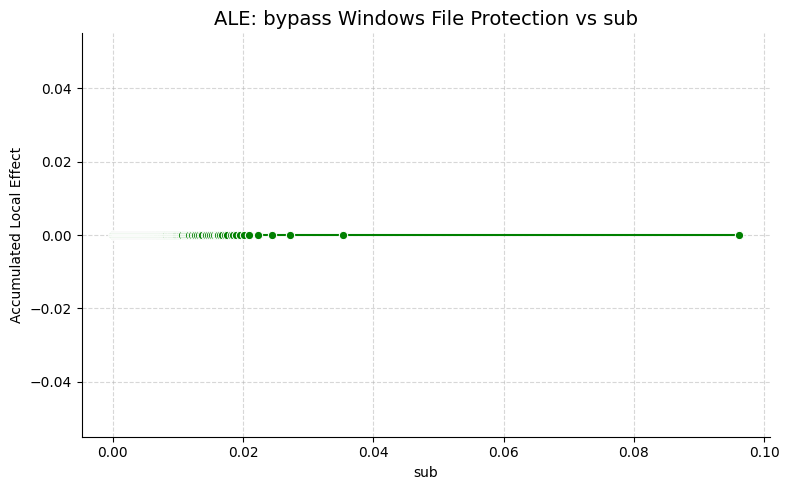

In [38]:
# Configuration
feature_to_plot = 'sub'
label_names = ['bypass Windows File Protection']

# Optionally scale ALE values
scaler = MinMaxScaler()
ale_scaled = scaler.fit_transform(ale_feature.reshape(-1, 1)).flatten()

# Create DataFrame for plotting
df_ale = pd.DataFrame({
    feature_to_plot: ale_grid,
    'ALE': ale_scaled
})

# Plot ALE curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_ale, x=feature_to_plot, y='ALE', marker='o', color='green')
sns.despine()
plt.title(f"ALE: {label_names[i]} vs {feature_to_plot}", fontsize=14)
plt.xlabel(feature_to_plot)
plt.ylabel("Accumulated Local Effect")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:
from alibi.explainers import ALE, plot_ale

# Configuration
feature_to_plot = 'sub'
label_names = ['bypass Windows File Protection']

# Loop through each binary classifier in OVR
for i, estimator in enumerate(model.estimators_[:1]):
    
    # Alibi requires a callable that returns predictions
    def predict_fn(X):
        return estimator.predict(X)

    # Initialize ALE explainer
    ale_explainer = ALE(predict_fn, feature_names=features, target_names=['sub'])

    # Fit ALE on the data
    ale_exp = ale_explainer.explain(X_test)

    # Get ALE data for the desired feature
    feature_idx = X_test.columns.get_loc(feature_to_plot)
    ale_feature = ale_exp.ale_values[feature_idx]
    ale_grid = ale_exp.feature_values[feature_idx]

    # Optionally scale ALE values
    scaler = MinMaxScaler()
    ale_scaled = scaler.fit_transform(ale_feature.reshape(-1, 1)).flatten()

    # Create DataFrame for plotting
    df_ale = pd.DataFrame({
        feature_to_plot: ale_grid,
        'ALE': ale_scaled
    })

    # Plot ALE curve
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_ale, x=feature_to_plot, y='ALE', marker='o', color='green')
    sns.despine()
    plt.title(f"ALE: {label_names[i]} vs {feature_to_plot}", fontsize=14)
    plt.xlabel(feature_to_plot)
    plt.ylabel("Accumulated Local Effect")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


InvalidIndexError: (slice(None, None, None), 0)

#### **LOFO** - Global

### **Local Methods**

#### **Lime** - Local

#### **ICE** - Local

#### **Anchors** - Local